#BIO462 Final Project: Characterizing ANTXR2/CMG2's role in cancer
Zach Eliason and Jacob Truman, Fall 2023

**INTRODUCTION**

 ANTXR2/CMG2 is most well known for its role in internalizing anthrax toxin. Recent research has also shown that ANTXR2/CMG2 also mediates growth-factor induced chemotaxis in angiogenesis, and this mode of action is inhibited upon treatment of an anthrax toxin subunit [[Cyran et al.,2022](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9250616/)]. As a hallmark of cancer, pathological angiogenesis plays a major role in tumor growth, but CMG2's role in cancer is still unclear. Lower CMG2 levels have been correlated with poor survival percentages in breast cancer patients  [[Ye et al.,2014](https://link.springer.com/article/10.1007/s00432-014-1650-2)]. Conversely, researchers have found that lower CMG2 levels in glioblastoma (brain cancer) patientis is associated with higher survival percentages [[Tan et al., 2018](https://pathsocjournals.onlinelibrary.wiley.com/doi/10.1002/path.5062)]. In an effort to understand CMG2's role in different cancer types, we performed a multi-omic pan-cancer analysis across data found in CPTAC to identify the role CMG2 plays in cancer. Characterization of CMG2's role in cancer has potential to provide new pathwasy for both an anti-angiogenic and general anti-cancer therapeutics.

In [ ]:
!pip install cptac==1.1.0

In [ ]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from sklearn.preprocessing import StandardScaler
from collections import Counter
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels
import warnings
import cptac
import copy

Because we want to perform a pan-cancer analysis of the gene CMG2, we need to download data for all cancer types available through CPTAC. We do this by calling each data type's respective function and storing the results in a dictionary to query later.


In [ ]:
cancers = {}

(We've tested this entire notebook multiple times and everything works correctly so long as you have a strong internet connection for the following code block—I haven't run into issues using the BYU campus wifi however)

In [ ]:
# Download all cancer types from CPTAC
cancer_types = cptac.list_datasets().index.values.tolist()

for cancer_type in cancer_types:
  if cancer_type in list(cancers.keys()):
    print("already downloaded", cancer_type)
    continue

  if hasattr(cptac, cancer_type) and callable(getattr(cptac, cancer_type)):
    if 'ucecconf' in cancer_type.lower():
      # this dataset is password protected?
      continue

    func = getattr(cptac, cancer_type)
    print(func)
    cptac.download(cancer_type)
    cancers[cancer_type] = func()
  else:
    print(f"{cancer_type} is either not an attribute or not callable")

print(cancers)

<class 'cptac.brca.Brca'>
<class 'cptac.ccrcc.Ccrcc'>
<class 'cptac.colon.Colon'>


/usr/local/lib/python3.10/dist-packages/cptac/colon.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prot_combined = prot_tumor.append(prot_normal)
/usr/local/lib/python3.10/dist-packages/cptac/colon.py:153: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  phos_combined = phos_tumor.append(phos_normal)


<class 'cptac.endometrial.Endometrial'>
<class 'cptac.gbm.Gbm'>
<class 'cptac.hnscc.Hnscc'>
<class 'cptac.lscc.Lscc'>
<class 'cptac.luad.Luad'>
<class 'cptac.ovarian.Ovarian'>
<class 'cptac.pdac.Pdac'>
GbmConf is either not an attribute or not callable
{'Brca': <cptac.brca.Brca object at 0x7fc27445a7a0>, 'Ccrcc': <cptac.ccrcc.Ccrcc object at 0x7fc259f38bb0>, 'Colon': <cptac.colon.Colon object at 0x7fc259f3af20>, 'Endometrial': <cptac.endometrial.Endometrial object at 0x7fc2394ecf40>, 'Gbm': <cptac.gbm.Gbm object at 0x7fc2394ef760>, 'Hnscc': <cptac.hnscc.Hnscc object at 0x7fc2394ec610>, 'Lscc': <cptac.lscc.Lscc object at 0x7fc2394ef970>, 'Luad': <cptac.luad.Luad object at 0x7fc259f30850>, 'Ovarian': <cptac.ovarian.Ovarian object at 0x7fc2394ec730>, 'Pdac': <cptac.pdac.Pdac object at 0x7fc2394ede10>}


cptac warning: The pdac data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-21-6de1ea71231b>, line 17)


We will want to perform tests later to determine differential expression between tumor and normal samples. This function accepts two datasets and checks all requisite statistical assumptions of the data before performing the most appropriate parametric or nonparametric test. It then returns a p-value for the test.

In [ ]:
def means_test(data1, data2):
    # Shapiro-Wilk test for normality
    _, p_value1 = shapiro(data1)
    _, p_value2 = shapiro(data2)

    sd1 = np.std(data1)
    sd2 = np.std(data2)

    if p_value1 > 0.05 and p_value2 > 0.05:
      # Welch's t-test
      if (max(sd1, sd2) > (3 * min(sd1, sd2))) or (min(len(data1), len(data2)) < 30):
        t_stat, p_value = ttest_ind(data1, data2, equal_var=False)
        return p_value
      else:
        # Student's t-test
        t_stat, p_value = ttest_ind(data1, data2, equal_var=True)
        return p_value
    else:
      # Mann Whitney U test
      mwu_stat, p_value = mannwhitneyu(data1, data2)
      return p_value

In addition to looking at CMG2, we want to investigate a cohort of related genes of interest and see how they compare across cancer types.

Genes of interest were compiled through a literature review from the following sources.

1.   [Sex Hormone-regulated CMG2 Is Involved in Breast and Prostate Cancer Progression](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9620450/)
2.   [CMG2 Expression Is an Independent Prognostic Factor for Soft Tissue Sarcoma Patients](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5751250/)
3. [CMG2/ANTXR2 regulates extracellular collagen VI which accumulates in hyaline fibromatosis syndrome](https://www.nature.com/articles/ncomms15861)
4. [Capillary morphogenesis protein 2 is a novel prognostic biomarker and plays oncogenic roles in glioma](https://pathsocjournals.onlinelibrary.wiley.com/doi/10.1002/path.5062)
5. [Ligand Binding to the Collagen VI Receptor Triggers a Talin-to-RhoA Switch that Regulates Receptor Endocytosis](https://www.sciencedirect.com/science/article/pii/S1534580720303178)
6. [ERK and c-Myc signaling in host-derived tumor endothelial cells is essential for solid tumor growth](https://www.pnas.org/doi/10.1073/pnas.2211927120)
7. [Chapter 10 (Angiogenesis) from Molecular Biology of Cancer: Mechanisms, Targets, and Therapeutics](https://www.amazon.com/Molecular-Biology-Cancer-Mechanisms-Therapeutics/dp/0198833024)
8. Preliminary analysis of mass spec data.

The genes of interest are stored in a list of lists because many of the genes have alternate naming schemas. This architecture correlates a gene's typical name to a list of potential gene names within CPTAC.

In [ ]:
names_to_genes = {"CMG2": ["ANTXR2"], "ANTXR1": ["ANTXR1"], "CREB1": ["CREB1"], "Oestrogen receptor": ["ESR1", "ESR", "NR3A1"], "Androgen receptor (AR)": ["AR", "KD", "AIS", "AR8", "TFM", "DHTR", "SBMA", "HYSP1", "NR3C4", "SMAX1", "HUMARA"], "CD26 (enzyme in charge of tissue remodeling?)": ["DPP4", "CD26", "ADABP", "ADCP2", "DPPIV", "TP103"], "uPAR (uPA receptor)": ["PLAUR", "CD87", "UPAR", "URKR", "U-PAR"], "uPA (secreted ligand)": ["PLAU", "ATF", "QPD", "UPA", "URK", "u-PA", "BDPLT5"], "PAI-1 (inhibitor)": ["PAI-1", "SERPINE1", "PAI1", "PLANH1"], "LGR5": ["FEX", "HG38", "GPR49", "GPR67", "GRP49", "LGR5"], "TGF-Beta1 (these two are the ones that showed significant differences from this)": ["TGFB1", "CED", "LAP", "DPD1", "TGFB", "IBDIMDE", "TGFbeta", "TGF-beta1"], "TNF": ["TNF", "DIF", "TNFA", "TNFSF2", "TNLG1F", "TNF-alpha"], "MMP14": ["MMP14", "MMP-14", "MMP-X1", "MT-MMP", "MT-MMP", "1", "MT1-MMP", "MT1MMP", "MTMMP1", "WNCHRS"], "MMP2": ["MMP2", "CLG4", "CLG4A", "MMP-2", "MMP-II", "MONA", "TBE-1"], "ERK": ["MAPK1", "ERK", "ERK-2", "ERK2", "ERT1", "MAPK2", "NS13", "P42MAPK", "PRKM1", "PRKM2", "p38", "p40", "p41", "p41mapk", "p42-MAPK"], "YAP1": ["YAP1", "COB1", "YAP", "YAP-1", "YAP2", "YAP65", "YKI"], "CCNB1 (regulates cell cycle)": ["CCNB1", "CCNB"], "ZEB-1": ["ZEB-1", "ZEB1", "AREB6", "BZP", "DELTAEF1", "FECD6", "NIL2A", "PPCD3", "TCF8", "ZFHEP", "ZFHX1A"], "Slug": ["SLUG", "SNAI2", "SLUGH", "SLUGH1", "SNAIL2", "WS2D"], "Vimentin": ["VIM"], "Talin": ["TLN1", "TLN", "ILWEQ"], "RhoA (And other rho GTPases?)": ["RHOA", "ARH12", "ARHA", "EDFAOB", "RHO12", "RHOH12"], "SRC (aka SRC kinase?)": ["SRC", "ASV", "SRC1", "THC6", "c-SRC", "p60-Src"], "Fyn (a kinase like src)": ["FYN", "SLK", "SYN", "p59-FYN"], "vinculin": ["VCL", "CMD1W", "CMH15", "HEL114", "MV", "MVCL", "VINC"], "MYL12A (aka MRLC3)": ["MYL12A", "HEL-S-24", "MLC-2B", "MLCB", "MRCL3", "MRLC3", "MYL2B"], "MEK1": ["MAP2K1", "CFC3", "MAPKK1", "MEK1", "MEL", "MKK1", "PRKMK1"], "MEK2": ["MAP2K2", "CFC4", "MAPKK2", "MEK2", "MKK2", "PRKMK2"], "MYC": ["MYC", "MRTL", "MYCC", "bHLHe39", "c-Myc"], "HIF1alpha": ["HIF1A", "HIF1", "MOP1", "PASD8", "HIF-1A", "bHLHe78", "HIF-1alpha", "HIF1-ALPHA", "HIF-1-alpha"], "VEGFA": ["VEGFA"], "VEGFB": ["VEGFB"], "VEGFC": ["VEGFC"], "VEGFD": ["VEGFD"], "VEGFR1": ["VEGFR1"], "VEGFR2": ["VEGFR2"], "VEGFR3": ["VEGFR3"], "TLN2": ["TLN2"], "H2B1B": ["STBP", "TH2B", "H2BFU", "TSH2B", "hTSH2B", "TSH2B.1", "HIST1H2BA", "bA317E16.3", "H2B1B"], "H2B1J": ["H2B1J", "HIST1H2BJ", "H2BC11", "H2B/r", "H2BFR", "H2BJ"], "H2B1O": ["H2B1O", "HIST1H2BO", "H2BC17", "H2B.2", "H2B/n", "H2BFN"], "H2B2E": ["H2B2E", "H2BC21", "H2BFQ", "HIST2H2BE"], "H2B3B": ["H2B3B", "H2BC26", "HIST3H2BB", "H2BU1"], "H2B1M": ["H2B1M", "H2BC14", "H2BFE", "HIST1H2BM"], "H2B1H": ["H2B1H", "H2BC9", "H2BFJ", "HIST1H2BH"], "H2B2F": ["H2B2F", "H2BC18", "HIST2H2BF"], "H2B1L": ["H2B1L", "H2BC13", "H2BFC", "HIST1H2BL"], "H2B1N": ["H2B1N", "H2BC15", "H2BFD", "HIST1H2BN"], "H2B1K": ["H2B1K", "H2BC12", "H2BFT", "HIRIP1", "HIST1H2BK"], "H2B1C": ["H2B1C", "H2BC4", "H2BFL", "HIST1H2BC", "H2BC6", "H2BFH", "HIST1H2BE", "H2BC7", "H2BFG", "HIST1H2BF", "H2BC8", "H2BFA", "HIST1H2BG", "H2BC10", "H2BFK", "HIST1H2BI"], "H2B1D": ["H2B1D", "H2BC5", "H2BFB", "HIRIP2", "HIST1H2BD"], "H2BFS": ["H2BFS", "H2BC12L", "H2BFS", "H2BS1"], "K1C13": ["KRT13", "K1C13"], "H13": ["H1-3", "H1F3", "HIST1H1D"], "SPB3": ["SERPINB3", "SCC", "T4-A", "SCCA1", "SSCA1", "SCCA-1", "HsT1196", "SCCA-PD", "SPB3"], "RL38": ["RPL38", "RL38"], "AP2micro": ["TFAP2A", "AP2TF", "TFAP2", "AP2A", ""], "beta-arrestin2": ["ARRB2", "ARB2", "ARR2", "BARR2"], "PAR1-clathrin adaptor": ["PAR1", "F2R", "CF2R", "PAR1", "TR"], "Integrin beta 3": ["ITB3", "ITGB3", "GP3A"], "Beta catenin": ["CTNNBIP1", "ICAT", "CNBP1"], "Raf": ["RAF1", "RAF"], "RHO": ["RHOC", "ARH9", "ARHC"], "Fak": ["FAK1", "PTK2", "FAK"], "LRP6": ["LRP6"], "LRP3": ["LRP3"], "Angiopoeitin 4": ["ANGP4", "ANGPT4", "ANG3", "ANG4"], "Angiopoeitin 2": ["ANGPT2"], "ANGP1": ["ANGP1", "ANGPT1", "KIAA0003"], "TIe receptor": ["TIE1", "TIE"], "ephrin": ["EFNB1", "EFL3", "EPLG2", "LERK2"], "ephrin receptor": ["EPHAA", "EPHA10"], "Angiosatin": ["PLG", "PLMN"]}

list_of_gene_lists = list(names_to_genes.values())

Now we are ready to query our multi-omics dataset from each of the cancer types we downloaded earlier. The function `get_all()` pulls transcriptomics, proteomics, and phosphoproteomics from each cancer type, if available. It filters each of these omics datasets down to a subset of clinical and omics columns. We pull the column `Sample_Tumor_Normal` from the clinical dataset and filter each omics dataset to include only the genes of interest we pass in.  Once the function finds a representative gene in each list of potential gene names, it continues on to the next gene of interest.

Following the methods found in [Dou et al., (2020)](https://doi.org/10.1016/j.cell.2020.01.026), for the phosphoproteomics of each gene of interest we average across all phosphosites, creating one consensus phosphoproteomic column per gene.

After selecting the multi-omics and clinical datasets, we join them into one consolidated dataframe for each cancer type. We then store each dataframe in a dictionary and return the dictionary. We chose not to join multiomics dataframes across cancer types because they each include a disjoint set of patients.

In [ ]:
# Put transcriptomics, proteomics, phosphoproteomics data for all cancer types in dict of dataframes
def get_all(cancers, list_of_gene_lists):

  # average each duplicate column names (for phosphosites etc)
  def average_duplicate_columns(df):
    transposed = df.T
    keep_columns = transposed.iloc[:2,:].T
    transposed = transposed.iloc[2:,:]
    transposed = transposed.groupby(transposed.index).mean()
    df = pd.concat([keep_columns, transposed.T], axis=1)
    return df


  # This will store our final dataframes to return
  cancer_type_dfs = {}

  # This is what each of the genes are going to be called in their respective omics dataframes
  # We use a nested list comprehension because the genes of interest are stored in a list of lists
  proteomics_genes = [[f"{x}_proteomics" for x in gene_names] for gene_names in list_of_gene_lists]
  transcriptomics_genes = [[f"{x}_transcriptomics" for x in gene_names] for gene_names in list_of_gene_lists]
  phosphoproteomics_genes = [[f"{x}_phosphoproteomics" for x in gene_names] for gene_names in list_of_gene_lists]

  for cancer_type in cancers:
    print(f"working on {cancer_type}")


    # Get transcriptomics
    transcriptomics_df = cancers[cancer_type].join_metadata_to_omics(metadata_df_name='clinical', omics_df_name='transcriptomics', metadata_cols = ["Sample_Tumor_Normal"])
    if isinstance(transcriptomics_df.columns, pd.MultiIndex):
      # Get rid of multilevel column indices, if any
      level_to_drop = transcriptomics_df.columns.names[1]
      transcriptomics_df = transcriptomics_df.droplevel(level_to_drop,axis=1)

    transcriptomics_columns = []
    transcriptomics_found = False
    for gene in transcriptomics_genes:
      for gene_name in gene:
        if gene_name in transcriptomics_df.columns.tolist():
          transcriptomics_found = True
          transcriptomics_columns.append(gene_name)
          break

    transcriptomics_df['cancer_type'] = cancer_type
    # Filter transcriptomics to only the clinical metadata columns and omics columns identified
    transcriptomics_df = transcriptomics_df[['cancer_type', 'Sample_Tumor_Normal'] + transcriptomics_columns]


    # Get proteomics
    proteomics_df = cancers[cancer_type].join_metadata_to_omics(metadata_df_name='clinical', omics_df_name='proteomics', metadata_cols = ["Sample_Tumor_Normal"])
    if isinstance(proteomics_df.columns, pd.MultiIndex):
      # Get rid of multilevel column indices, if any
      level_to_drop = proteomics_df.columns.names[1]
      proteomics_df = proteomics_df.droplevel(level_to_drop,axis=1)

    proteomics_columns = []
    proteomics_found = False
    for gene in proteomics_genes:
      for gene_name in gene:
        if gene_name in proteomics_df.columns.tolist():
          proteomics_found = True
          proteomics_columns.append(gene_name)
          break

    proteomics_df['cancer_type'] = cancer_type
    # Filter proteomics to only the clinical metadata columns and omics columns identified
    proteomics_df = proteomics_df[['cancer_type', 'Sample_Tumor_Normal'] + proteomics_columns]

    # Sometimes there are a couple duplicated omics columns in the proteomics data. This takes the average across those duplicates
    proteomics_df = average_duplicate_columns(proteomics_df)


    # Get phosphoproteomics
    phosphoproteomics_df = cancers[cancer_type].join_metadata_to_omics(metadata_df_name='clinical', omics_df_name='phosphoproteomics', metadata_cols = ["Sample_Tumor_Normal"])
    if isinstance(phosphoproteomics_df.columns, pd.MultiIndex):
      level_to_drop = phosphoproteomics_df.columns.names[-1]
      phosphoproteomics_df = phosphoproteomics_df.droplevel(level_to_drop,axis=1)

    phosphoproteomics_columns = []
    phosphoproteomics_found = False
    for gene in phosphoproteomics_genes:
      for gene_name in gene:
        if gene_name in [x[0] for x in phosphoproteomics_df.columns.tolist()]:
          phosphoproteomics_found = True
          phosphoproteomics_columns.append(gene_name)
          break

    phosphoproteomics_df['cancer_type'] = cancer_type

    # Filter phosphoproteomics to only the clinical metadata columns and omics columns identified
    phosphoproteomics_df = phosphoproteomics_df[['cancer_type', 'Sample_Tumor_Normal'] + phosphoproteomics_columns]

    # take the mean for each gene across phosphosites
    new_phosphoproteomics_df = phosphoproteomics_df.copy().droplevel(phosphoproteomics_df.columns.names[1:], axis=1)
    phosphoproteomics_df = average_duplicate_columns(new_phosphoproteomics_df)


    # Merge transcriptomics, proteomics, and phosphoproteomics
    df = pd.merge(transcriptomics_df, proteomics_df, how='outer', left_index=True, right_index=True, suffixes=('', '_DROP'))
    df = pd.merge(df, phosphoproteomics_df, how='outer', left_index=True, right_index=True, suffixes=('', '_DROP'))

    # Drop columns duplicated across the merged dfs
    df = df.filter(regex='^(?!.*_DROP$)')

    cancer_type_dfs[cancer_type] = df

  return cancer_type_dfs

Now we call the `get_all()` function to store multiomic data for each gene of interest across cancer types.

In [ ]:
dict_of_cancer_dfs = get_all(cancers, list_of_gene_lists)

working on Brca
working on Ccrcc


cptac warning: transcriptomics data was not found for the following samples, so transcriptomics data columns were filled with NaN for these samples: C3L-00183.N, C3L-00791.N, C3N-00246.N, C3N-00312.N, C3N-00317.N, C3N-00320.N, C3N-00437.N, C3N-00492.N, C3N-00953.N (<ipython-input-24-32864d82b9e8>, line 28)


working on Colon


cptac warning: transcriptomics data was not found for the following samples, so transcriptomics data columns were filled with NaN for these samples: 01CO001.N, 01CO005.N, 01CO006.N, 01CO008.N, 01CO013.N, 01CO014.N, 01CO015.N, 01CO019.N, 01CO022.N, 05CO002.N, 05CO003.N, 05CO004, 05CO006.N, 05CO007.N, 05CO011.N, 05CO015.N, 05CO020.N, 05CO026.N, 05CO028.N, 05CO029.N, 05CO032.N, 05CO033.N, 05CO034.N, 05CO035.N, 05CO037.N, 05CO039.N, 05CO041.N, 05CO044.N, 05CO045.N, 05CO047.N, 05CO048.N, 05CO049.N, 05CO050.N, 05CO053.N, 05CO054.N, 06CO001.N, 06CO002.N, 09CO005.N, 09CO006.N, 09CO008.N, 09CO011.N, 09CO013.N, 09CO014.N, 09CO015.N, 09CO018.N, 09CO019.N, 09CO022.N, 11CO005.N, 11CO007.N, 11CO008.N, 11CO010.N, 11CO018.N, 11CO019.N, 11CO020.N, 11CO021.N, 11CO022.N, 11CO027.N, 11CO030.N, 11CO031.N, 11CO032.N, 11CO033.N, 11CO036.N, 11CO037.N, 11CO039.N, 11CO042.N, 11CO043.N, 11CO044.N, 11CO045.N, 11CO047.N, 11CO048.N, 11CO051.N, 11CO052.N, 11CO053.N, 11CO054.N, 11CO057.N, 11CO058.N, 11CO060.N, 11CO06

working on Endometrial


cptac warning: transcriptomics data was not found for the following samples, so transcriptomics data columns were filled with NaN for these samples: C3L-00563.N, C3L-00605.N, C3L-00769.N, C3L-00770.N, C3L-00771.N, C3L-00930.N, C3L-00947.N, C3L-00963.N, C3L-01246.N, C3L-01249.N, C3L-01252.N, C3L-01256.N, C3L-01257.N, C3L-01744.N, C3N-00200.N, C3N-00729.N, C3N-01211.N, NX1.N, NX10.N, NX11.N, NX12.N, NX13.N, NX14.N, NX15.N, NX16.N, NX17.N, NX18.N, NX2.N, NX3.N, NX4.N, NX5.N, NX6.N, NX7.N, NX8.N, NX9.N (<ipython-input-24-32864d82b9e8>, line 28)
<ipython-input-24-32864d82b9e8>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  transposed = transposed.groupby(transposed.index).mean()


working on Gbm


cptac warning: transcriptomics data was not found for the following samples, so transcriptomics data columns were filled with NaN for these samples: C3L-01839, C3L-03747, C3N-01370, C3N-01817, C3N-01850, C3N-03187, PT-Q2AG.N (<ipython-input-24-32864d82b9e8>, line 28)
cptac warning: proteomics data was not found for the following samples, so proteomics data columns were filled with NaN for these samples: C3L-01839, C3L-03747, C3N-01370, C3N-01817, C3N-01850, C3N-03187 (<ipython-input-24-32864d82b9e8>, line 49)
cptac warning: phosphoproteomics data was not found for the following samples, so phosphoproteomics data columns were filled with NaN for these samples: C3L-01839, C3L-03747, C3N-01370, C3N-01817, C3N-01850, C3N-03187 (<ipython-input-24-32864d82b9e8>, line 73)


working on Hnscc


cptac warning: transcriptomics data was not found for the following samples, so transcriptomics data columns were filled with NaN for these samples: C3L-00994.C, C3L-02617.C, C3L-04350.C, C3L-04354.N, C3L-04791.N, C3L-04844.N, C3L-05257.C, C3N-00295.N, C3N-00300, C3N-00829.N, C3N-00857.N, C3N-01620.N, C3N-01643, C3N-01757.C, C3N-01758.N, C3N-01858.N, C3N-01859.N, C3N-02693.N, C3N-03008.N, C3N-03011.N, C3N-03012.N, C3N-03013.N, C3N-03015.N, C3N-03042.C, C3N-03781.N, C3N-04275.N, C3N-04276.N, C3N-04277.N, C3N-04278.N, C3N-04279.N (<ipython-input-24-32864d82b9e8>, line 28)
cptac warning: proteomics data was not found for the following samples, so proteomics data columns were filled with NaN for these samples: C3L-00977.N, C3L-04025.N, C3L-04791.N, C3N-00300, C3N-01643, C3N-01948.N, C3N-02333.N, C3N-02727.N, C3N-02925.N, C3N-03226.N, C3N-03487.N, C3N-03889.N, C3N-04152.N, C3N-04611.N (<ipython-input-24-32864d82b9e8>, line 49)
cptac warning: phosphoproteomics data was not found for the foll

working on Lscc


cptac warning: transcriptomics data was not found for the following samples, so transcriptomics data columns were filled with NaN for these samples: C3L-00503, C3L-00503.N, C3L-02624, C3L-02624.N, C3L-02646.N, C3N-00309, C3N-00839, C3N-01018, C3N-01018.N, C3N-02300.N, C3N-03072.N, C3N-03662.N, C3N-03886.N, C3N-04155.N, Samples-altered, Samples-amp, Samples-del (<ipython-input-24-32864d82b9e8>, line 28)
cptac warning: proteomics data was not found for the following samples, so proteomics data columns were filled with NaN for these samples: C3L-00503, C3L-00503.N, C3L-02624, C3L-02624.N, C3N-00309, C3N-00839, C3N-01018, C3N-01018.N, C3N-02300.N, Samples-altered, Samples-amp, Samples-del (<ipython-input-24-32864d82b9e8>, line 49)
cptac warning: phosphoproteomics data was not found for the following samples, so phosphoproteomics data columns were filled with NaN for these samples: C3L-00503, C3L-00503.N, C3L-02624, C3L-02624.N, C3N-00309, C3N-00839, C3N-01018, C3N-01018.N, C3N-02300.N, Sam

working on Luad
working on Ovarian


cptac warning: transcriptomics data was not found for the following samples, so transcriptomics data columns were filled with NaN for these samples: 01OV007.N, 01OV008.N, 01OV010.N, 01OV013.N, 01OV017.N, 01OV019.N, 01OV023.N, 01OV024, 01OV029, 01OV029.N, 01OV033, 01OV039.N, 02OV001, 02OV001.N, 11OV002.N, 11OV010, 11OV010.N, 14OV011.N, 14OV029, 14OV029.N, 15OV001.N, 17OV001.N, 17OV002.N, 17OV003, 17OV003.N, 17OV004, 17OV004.N, 17OV005, 17OV005.N, 17OV012 (<ipython-input-24-32864d82b9e8>, line 28)
cptac warning: proteomics data was not found for the following samples, so proteomics data columns were filled with NaN for these samples: 01OV002, 01OV008, 01OV010, 01OV013, 01OV019, 01OV024, 01OV033, 01OV045, 01OV046, 01OV049, 02OV001, 02OV035, 02OV040, 02OV042, 02OV045, 04OV041, 11OV009, 11OV010, 13OV004, 14OV029, 17OV003, 17OV004, 17OV005, 17OV012, 17OV019, 17OV034, 22OV001, 26OV010 (<ipython-input-24-32864d82b9e8>, line 49)
cptac warning: phosphoproteomics data was not found for the follow

working on Pdac


cptac warning: transcriptomics data was not found for the following samples, so transcriptomics data columns were filled with NaN for these samples: C3L-00017.N, C3L-00189.N, C3L-00277.N, C3L-00401.N, C3L-00589.N, C3L-00622.N, C3L-00881.N, C3L-00928.N, C3L-01031.N, C3L-01036.N, C3L-01037.N, C3L-01051.N, C3L-01052.N, C3L-01053.N, C3L-01054.N, C3L-01124.N, C3L-01328.N, C3L-01453.N, C3L-01598.N, C3L-01689.N, C3L-01703.N, C3L-01971.N, C3L-02112.N, C3L-02463.N, C3L-02613.N, C3L-03129, C3L-03356.N, C3L-03371, C3L-03388.N, C3L-03395.N, C3L-03513.N, C3L-03514.N, C3L-03515.N, C3L-03630.N, C3L-03632.N, C3L-03639.N, C3L-03743.N, C3L-04027.N, C3L-04080.N, C3L-04473.N, C3L-04475.N, C3L-04479.N, C3L-04495.N, C3L-04848.N, C3L-04853.N, C3L-07032.N, C3L-07033.N, C3L-07034.N, C3L-07035.N, C3L-07036.N, C3N-00198.N, C3N-00249.N, C3N-00512.N, C3N-00513.N, C3N-00514.N, C3N-00709.N, C3N-00957.N, C3N-01379, C3N-01719.N, C3N-01900, C3N-01907, C3N-01997.N, C3N-02295.N, C3N-02573.N, C3N-02585.N, C3N-02592.N, C3N

Because differential CMG2 abundance is correlated with different survival outcomes across different cancers, we felt it important to understand how CMG2 is expressed across all cancer and omics types available through CPTAC. To do this, we first wrote the function `create_diff_exp_df` to create a dataframe containing data for CMG2 across all cancer and omics types (inclusive of transcriptomics, proteomics, and phosphoproteomics) along with the `Sample_Tumor_Normal` column.

Upon creating this dataframe, the function performs means testing on tumor vs. normal data for each of the cancer type/omics pairs. We interpret the p-value for each tumor/normal means test against Bonferroni-adjusted alpha values ([Haynes, 2013](https://doi.org/10.1007/978-1-4419-9863-7_1213)) which are divided by the total number of tests performed.

Finally, the function returns the dataframe `p_values` containing the raw p-values for each differential expression test, the dataframe `quantized_p_values` containing its significance level according to the adjusted alpha values (ranging from 1 to 3 for cancers where CMG2 has higher abundance in the mutated type, and ranging from -1 to -3 where CMG2 has higher abundance in the wildtype), and the list `significance_levels` containing the adjusted alpha values themselves.


In [ ]:
warnings.filterwarnings('ignore', message="The default dtype for empty Series will be 'object' instead of 'float64' in a future version", category=FutureWarning)

def create_diff_exp_df(dict_of_cancer_dfs, gene_of_interest="ANTXR2"):
  num_tests = 0
  p_values = {}
  for cancer_type, df in dict_of_cancer_dfs.items():

    p_values[cancer_type] = {}

    columns_to_keep = [x for x in df.columns if x.startswith(gene_of_interest)]

    for column in columns_to_keep:
      if 'normalized' in column:
        continue
      gene_name, omics_type = column.split("_")
      temp_df = df[['Sample_Tumor_Normal'] + [column]].copy().dropna()

      tumor_data = temp_df[temp_df['Sample_Tumor_Normal'] == "Tumor"][column].values
      normal_data = temp_df[temp_df['Sample_Tumor_Normal'] == "Normal"][column].values

      if len(tumor_data) < 3 or len(normal_data) < 3:
        p_values[cancer_type][omics_type] = None
        continue

      p_value = means_test(tumor_data, normal_data)
      num_tests += 1

      delta = tumor_data.mean() - normal_data.mean()
      sign = 1 if delta > 0 else -1

      p_value *= sign

      p_values[cancer_type][omics_type] = p_value

  significance_levels = np.array([.001, .01, .05, 0, .05, .01, .001]) / num_tests

  p_values = pd.DataFrame(p_values)

  def get_discrete_significance(value):
    if value is None:
      return None
    elif (-.05 / num_tests) < value < (-.01 / num_tests):
      return -1
    elif (-.01 / num_tests) < value < (-.001 / num_tests):
      return -2
    elif (-.001 / num_tests) < value < (0 / num_tests):
      return -3
    elif 0 < value < (.001 / num_tests):
      return 3
    elif (.001 / num_tests) < value < (.01 / num_tests):
      return 2
    elif (.01 / num_tests) < value < (.05 / num_tests):
      return 1
    else:
      return 0

  quantized_p_values = p_values.applymap(get_discrete_significance)

  return p_values, quantized_p_values, significance_levels

Our next function `plot_diff_exp_heatmap()` creates a heatmap from the significance levels of these p-values. Positive  values (green in figure 1.) indicate higher expression of that omics data in the mutant tissue than normal. Conversely, negative (or purple) values indicate a higher expression of the wildtype gene. The strength of the color correlates to the significance of the p-value.

In [ ]:
# The styling of this heatmap is adapted from code found at
# https://python-graph-gallery.com/web-heatmap-and-radial-barchart-plastics/

def plot_diff_exp_heatmap(df, significance_levels):
  color_bar_name="Differential Expression"
  xlabel="CMG2 in Cancer Type"
  ylabel="Omics Type"

  plt.style.use('default')
  levels = np.linspace(-3, 3, 8)  # 7 discrete steps from -3 to 3

  # Create a discrete colormap
  cmap = plt.cm.get_cmap('PiYG', len(levels) - 1)

  fig, ax = plt.subplots(figsize=(15, 4))

  i = 0
  x_labels = []
  x_names = df["cancer_type"].unique()
  for x_name in x_names:
    d = df[df["cancer_type"] == x_name]
    d = d.dropna()

    y = d["omics_type"]
    if len(d) < 1:
      continue

    x = [i] * len(y)

    color = cmap(np.digitize(d['significance'], levels) - 1)

    ax.scatter(x, y, color=color, s=320)
    i += 1
    x_labels.append(x_name)

  # Remove all spines
  ax.set_frame_on(False)
  ax.grid(alpha=0.5)
  ax.set_axisbelow(True)

  # Set position for x ticks
  ax.set_xticks(np.arange(len(x_labels)))
  ax.set_xticklabels(x_labels)

  # Remove tick marks by setting their size to 0. Set text color to "0.3" (a type of grey)
  ax.tick_params(size=0, colors="0.3")
  ax.set_xlabel(xlabel, loc="center")
  ax.set_ylabel(ylabel, loc="center")

  plt.xticks(rotation=90)
  plt.tight_layout()

  # Add a colorbar
  sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-3, vmax=3))
  sm.set_array([])

  cbar = plt.colorbar(sm, ax=ax)
  cbar.set_label(color_bar_name)
  cbar.outline.set_visible(False)

  # Set custom tick labels for the colorbar
  print([x for x in significance_levels])
  cbar.ax.set_yticklabels(["p-value < {:.1e}".format(level) if level != 0 else "n.s." for level in significance_levels])


  plt.title(f"Differential Expression of CMG2 Between Tumor/Normal Tissues\n Across Cancer and Omics Types", fontsize=16)

  return ax

In this code block, we now call the previous two functions. There is a layer of formatting we have to do before calling `plot_diff_exp_heatmap()`. This involves melting our dataframe into a longer list and ordering them by significance level. This will help us identify patterns in the data.

[5.882352941176471e-05, 0.0005882352941176471, 0.0029411764705882353, 0.0, 0.0029411764705882353, 0.0005882352941176471, 5.882352941176471e-05]


<ipython-input-27-d9939751fa2a>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('PiYG', len(levels) - 1)
<ipython-input-27-d9939751fa2a>:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(["p-value < {:.1e}".format(level) if level != 0 else "n.s." for level in significance_levels])


<Axes: title={'center': 'Differential Expression of CMG2 Between Tumor/Normal Tissues\n Across Cancer and Omics Types'}, xlabel='CMG2 in Cancer Type', ylabel='Omics Type'>

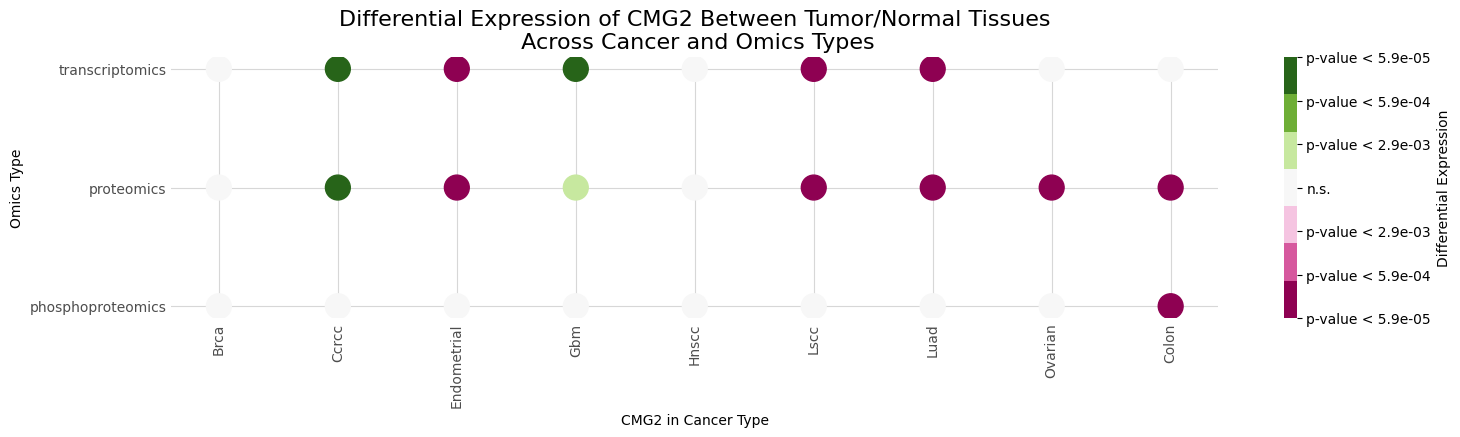

In [ ]:
p_values, quantized_p_values, significance_levels = create_diff_exp_df(dict_of_cancer_dfs)
quantized_p_values = quantized_p_values.fillna(pd.NA)
melted_significances = pd.melt(quantized_p_values.reset_index().rename(columns={'index': 'omics_type'}), id_vars='omics_type', value_vars=quantized_p_values.columns.tolist(), var_name='cancer_type', value_name='significance')

melted_significances = melted_significances.sort_values(by=['omics_type', 'significance'], ascending=[True, False])
# melted_significances['cancer_type'] = melted_significances['cancer_type'].astype(str)
# melted_significances['omics_type'] = melted_significances['omics_type'].astype(str)

plot_diff_exp_heatmap(melted_significances, significance_levels)

**FIGURE 1**

Using the CPTAC dataset, we first sought to replicate the differing CMG2 expression levels across cancer types. We found, similar to already published work, that CMG2 has higher expression levels in GBM. We also found higher CMG2 levels in CCRCC. Conversely, we found that Endometrial, LSCC, LUAD, Ovarian and Colon cancers had lower levels of CMG2. These data further validate that CMG2 expression levels differ across cancer types. It is important to take into account the tissue type and location dependent pathological angiogenesis thresholds of each cancer type. Some tissues and locations, like the lungs, are better able to handle pathological angiogenesis. Meanwhile, when pathological angiogenesis occurs in tissues like the brain, patient survival could dramatically decrease. Whie CMG2 has been reported to be involved in angiogenesis, these data suggest that CMG2 may be involved in a different hallmark of cancer.


---------------------------------------------------------------------------------------------------------------------------

Next we want to compare transcriptomics and proteomics between cancer types for CMG2. The function `get_corr_coef()` calculates the Pearson's correlation coefficient between transcriptomic and proteomic levels for tumor and normal type in each of the cancer types.

In [ ]:
## Get the calculated pearson's correlation coefficients between transcriptomic and proteomic levels.
def get_corr_coef (original_dict_of_cancer_dfs, gene_of_interest):

  # We copy the dictionary first so that we don't overwrite its contents for future analysis
  dict_of_cancer_dfs = copy.copy(original_dict_of_cancer_dfs)

  cancer_types_to_test = []
  cancer_plot_types = list(dict_of_cancer_dfs.keys())
  for i, cancer_type in enumerate(cancer_plot_types):
    df = dict_of_cancer_dfs[cancer_type]
    df = df[['Sample_Tumor_Normal'] + [x for x in df.columns if x.startswith(gene_of_interest)]]
    df = df.dropna()

    scaler = StandardScaler()
    df[f"{gene_of_interest}_transcriptomics_normalized"] = scaler.fit_transform(df[[f"{gene_of_interest}_transcriptomics"]])

    scaler = StandardScaler()
    df[f"{gene_of_interest}_proteomics_normalized"] = scaler.fit_transform(df[[f"{gene_of_interest}_proteomics"]])

    df.sort_values([f'{gene_of_interest}_proteomics_normalized'])
    dict_of_cancer_dfs[cancer_type] = df

    normal_proteomic_data = df[df['Sample_Tumor_Normal'] == 'Normal'][f'{gene_of_interest}_proteomics_normalized']
    normal_transcriptomic_data = df[df['Sample_Tumor_Normal'] == 'Normal'][f'{gene_of_interest}_transcriptomics_normalized']
    if len(normal_proteomic_data) >= 3 and len(normal_transcriptomic_data) >= 3:
      cancer_types_to_test.append(cancer_type)

    cmbd_df = {}
    for i in cancer_types_to_test:
      if i in dict_of_cancer_dfs:
        cmbd_df[i]=dict_of_cancer_dfs[i]

  mrna_prot_corr = {}
  for cancer_type in cmbd_df:
    df = cmbd_df[cancer_type]
    tumor = df[df['Sample_Tumor_Normal']=='Tumor'][['Sample_Tumor_Normal','ANTXR2_transcriptomics_normalized',"ANTXR2_proteomics_normalized"]]
    normal = df[df['Sample_Tumor_Normal']=='Normal'][['Sample_Tumor_Normal','ANTXR2_transcriptomics_normalized',"ANTXR2_proteomics_normalized"]]
    tissue = [tumor,normal]
    count = 0
    for t in tissue:
      corr, pval = stats.pearsonr(t['ANTXR2_transcriptomics_normalized'],t['ANTXR2_proteomics_normalized'])
      if count == 0:
        calcs = [corr,pval]
        mrna_prot_corr[f'{cancer_type}_Tumor']=calcs
        count +=1
      elif count ==1:
        calcs = [corr,pval]
        mrna_prot_corr[f'{cancer_type}_Normal']=calcs
        count =0

  a = pd.DataFrame.from_dict(mrna_prot_corr, orient='index',columns=[ 'Correlation_Coefficient', 'Pvalue'])
  corrected_pval = list(statsmodels.stats.multitest.multipletests(a['Pvalue'],alpha = .05,method='fdr_bh')[1])

  a['Ben_Hoch_Corrected_Pval']=corrected_pval
  corr_coef = a[['Correlation_Coefficient',"Ben_Hoch_Corrected_Pval"]]
  return corr_coef

get_corr_coef(dict_of_cancer_dfs,"ANTXR2")

,Correlation_Coefficient,Ben_Hoch_Corrected_Pval
Ccrcc_Tumor,0.555105,4.078715e-09
Ccrcc_Normal,0.333870,8.115381e-03
Endometrial_Tumor,0.586795,1.238104e-09
Endometrial_Normal,0.438528,1.401079e-01
Gbm_Tumor,0.757852,6.491386e-19
Gbm_Normal,0.057343,8.835013e-01
Hnscc_Tumor,0.678032,1.450930e-14
Hnscc_Normal,0.506846,1.984356e-03
Lscc_Tumor,0.764049,8.056716e-21
Lscc_Normal,0.236466,3.101114e-02


The function `plot_transcriptomics_proteomics()` creates a figure that plots a regression line between transcriptomics and proteomics and boxplots for differential expression between tumor and normal samples across RNA and protein abundance for each cancer type.

The Bonferroni-adjusted significance of each differential expression test are indicated in number of stars above each boxplot.

<Figure size 640x480 with 0 Axes>

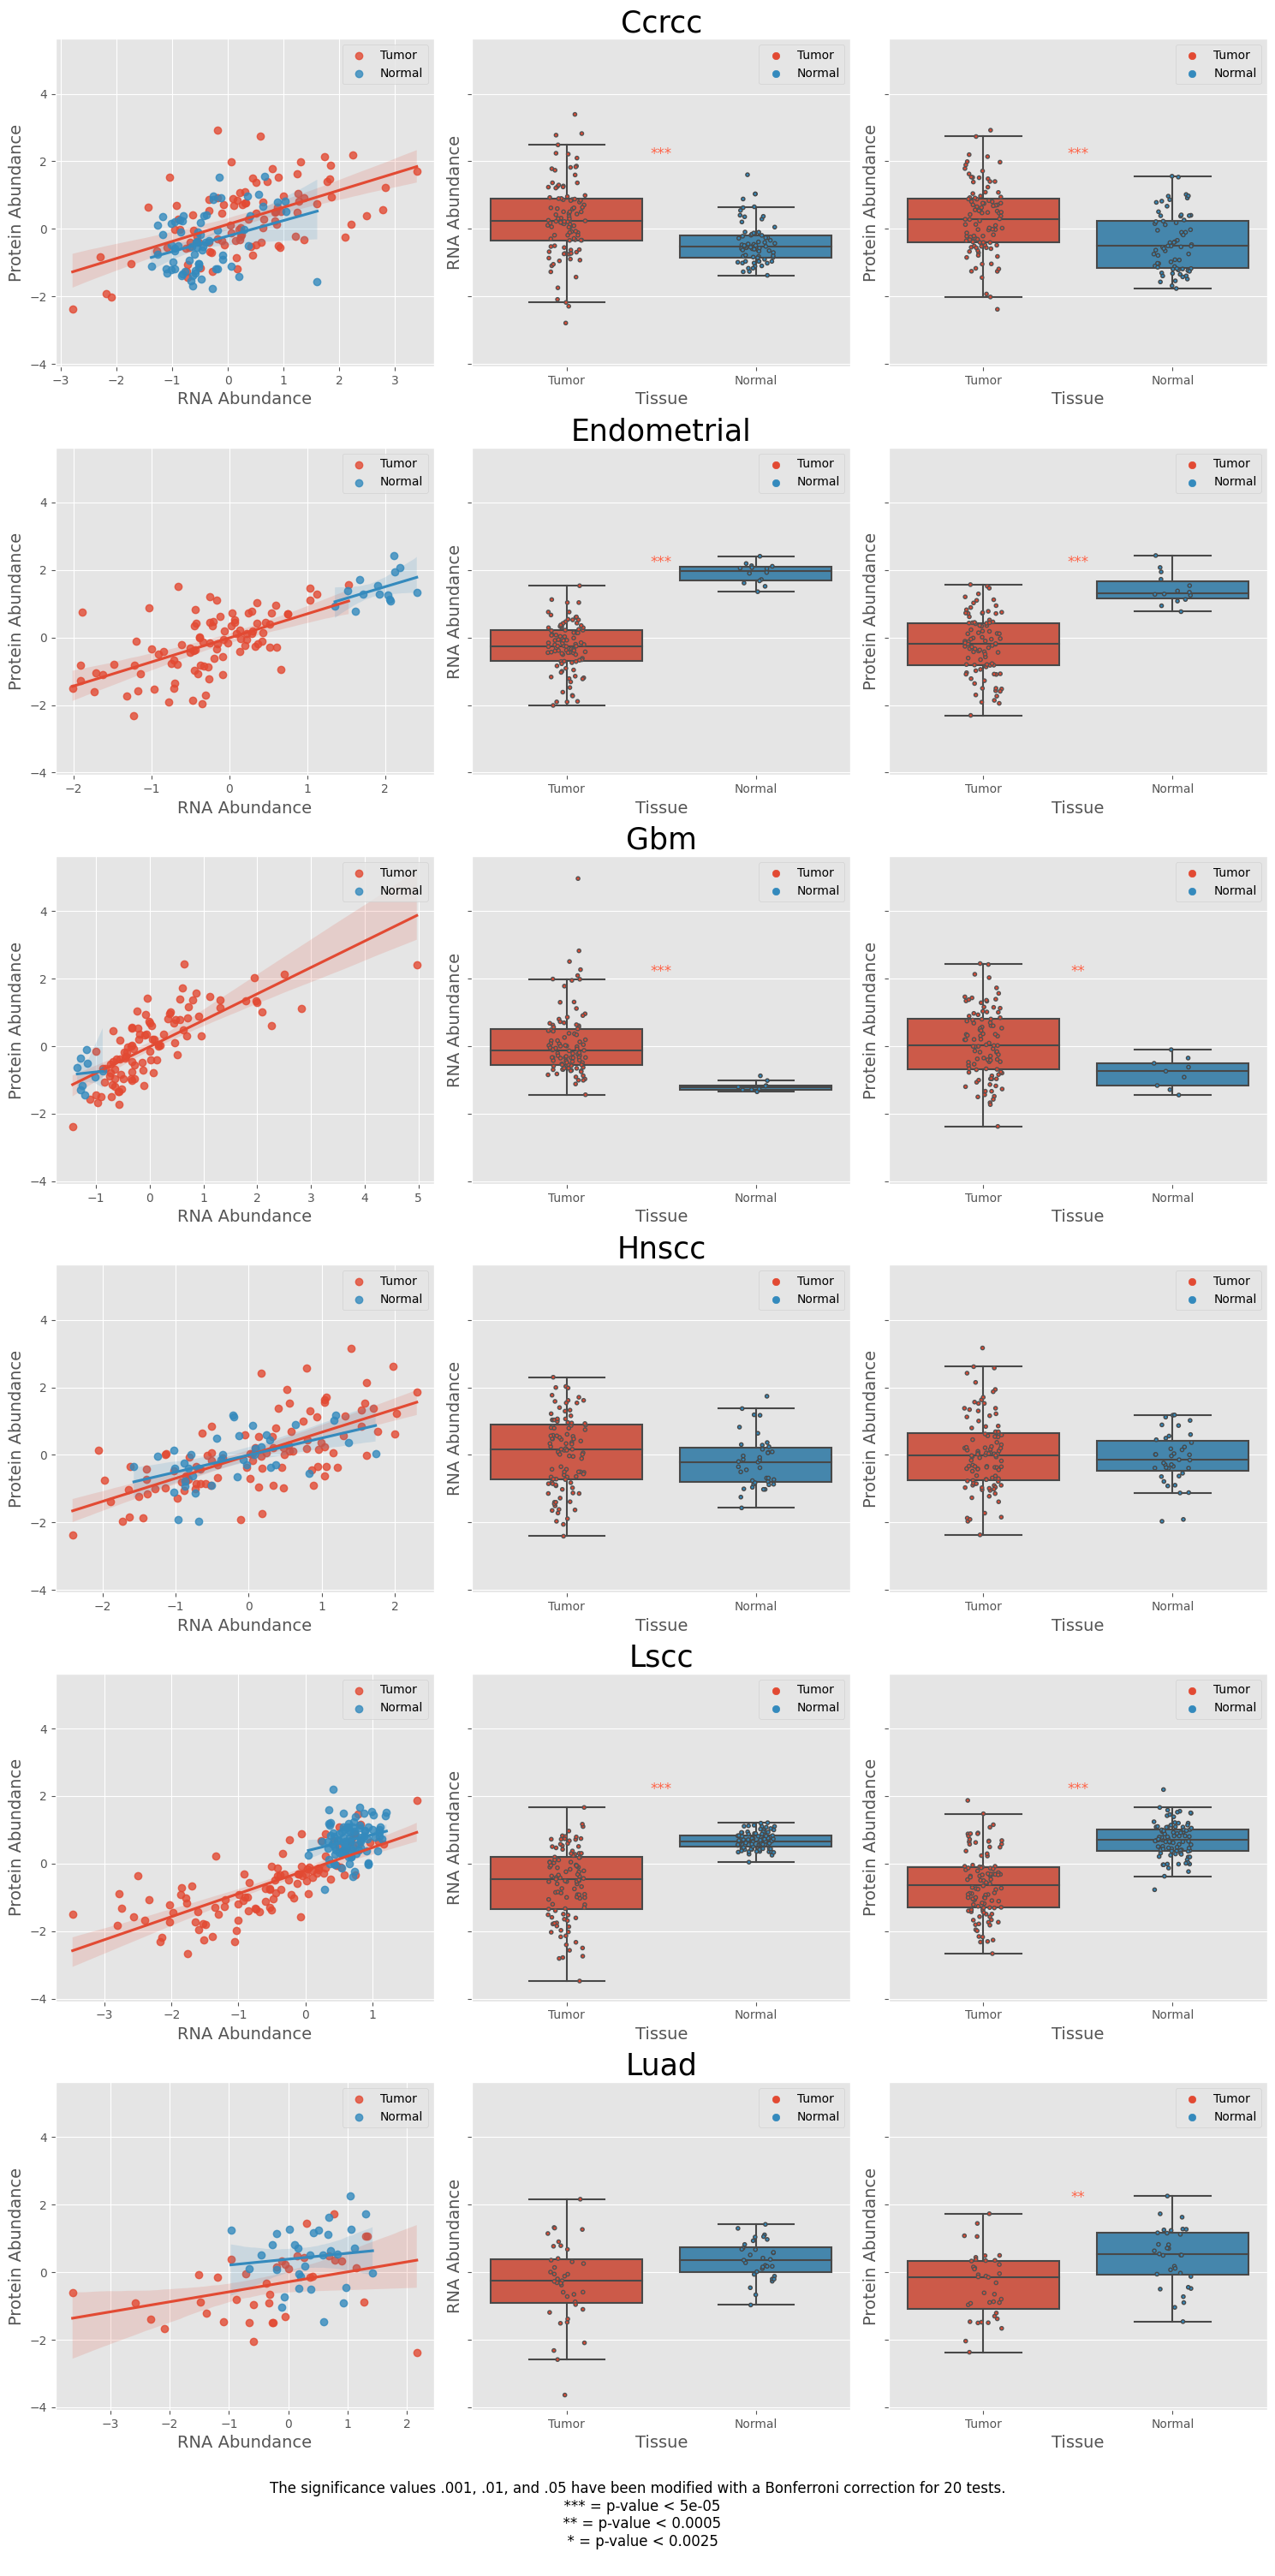

In [ ]:
def plot_transcriptomics_proteomics(original_dict_of_cancer_dfs, gene_of_interest):
  dict_of_cancer_dfs = copy.copy(original_dict_of_cancer_dfs)

  titlesize = 25
  axissize = 14

  plt.style.use('ggplot')
  plt.rcParams['figure.facecolor'] = 'white'
  plt.figure(facecolor='white')
  # plt.rcParams['grid.color'] = 'grey'

  # Hide warnings!
  pd.options.mode.chained_assignment = None

  cancer_plot_types = list(dict_of_cancer_dfs.keys())

  significance_values = [0.001, 0.01, 0.05]
  num_tests = 2 * len(cancer_plot_types)
  significance_values = [x / num_tests for x in significance_values]


  cancer_types_to_test = []
  for i, cancer_type in enumerate(cancer_plot_types):
    df = dict_of_cancer_dfs[cancer_type]
    df = df[['Sample_Tumor_Normal'] + [x for x in df.columns if x.startswith(gene_of_interest)]]
    df = df.dropna()

    scaler = StandardScaler()
    df[f"{gene_of_interest}_transcriptomics_normalized"] = scaler.fit_transform(df[[f"{gene_of_interest}_transcriptomics"]])

    scaler = StandardScaler()
    df[f"{gene_of_interest}_proteomics_normalized"] = scaler.fit_transform(df[[f"{gene_of_interest}_proteomics"]])

    df.sort_values([f'{gene_of_interest}_proteomics_normalized'])
    dict_of_cancer_dfs[cancer_type] = df

    normal_proteomic_data = df[df['Sample_Tumor_Normal'] == 'Normal'][f'{gene_of_interest}_proteomics_normalized']
    normal_transcriptomic_data = df[df['Sample_Tumor_Normal'] == 'Normal'][f'{gene_of_interest}_transcriptomics_normalized']
    if len(normal_proteomic_data) >= 3 and len(normal_transcriptomic_data) >= 3:
      cancer_types_to_test.append(cancer_type)


  fig, axes = plt.subplots(len(cancer_types_to_test), 3, figsize=(15, 5 * len(cancer_types_to_test)), sharey=True, facecolor='white')
  sns.color_palette("Paired")

  for i, cancer_type in enumerate(cancer_types_to_test):
    # Regression Line
    ax = axes[i, 0]
    data = dict_of_cancer_dfs[cancer_type]

    for tissue_type in data['Sample_Tumor_Normal'].unique():
      tissue_data = data[data['Sample_Tumor_Normal'] == tissue_type]
      sns.regplot(data=tissue_data, x=f'{gene_of_interest}_transcriptomics_normalized', y=f'{gene_of_interest}_proteomics_normalized', ax=ax, label=tissue_type)

    ax.legend()
    ax.set_xlabel("RNA Abundance", fontsize=axissize)
    ax.set_ylabel("Protein Abundance", fontsize=axissize)


    # Transcriptomics Boxplot
    ax = axes[i, 1]

    tumor_data = data[data['Sample_Tumor_Normal'] == 'Tumor'][f'{gene_of_interest}_transcriptomics_normalized']
    normal_data = data[data['Sample_Tumor_Normal'] == 'Normal'][f'{gene_of_interest}_transcriptomics_normalized']

    # p_value = stats.ttest_ind(tumor_data, normal_data).pvalue
    p_value = means_test(normal_data, tumor_data)
    significance = sum([p_value < x for x in significance_values]) * "*"

    max_point = max(df[f'{gene_of_interest}_transcriptomics_normalized'].max(), df[f'{gene_of_interest}_proteomics_normalized'].max())
    ax.text(0.5, max_point, significance, ha='center', va='center', fontsize=12, c='tomato')

    sns.boxplot(data=data, x='Sample_Tumor_Normal', y=f'{gene_of_interest}_transcriptomics_normalized', ax=ax, showfliers=False)
    sns.stripplot(data=data, x="Sample_Tumor_Normal", y=f'{gene_of_interest}_transcriptomics_normalized', dodge=False, size=3, ax=ax, hue='Sample_Tumor_Normal', hue_order = ["Tumor", "Normal"], linewidth=1)

    ax.set_title(cancer_type, fontsize=titlesize)
    ax.set_xlabel('Tissue', fontsize=axissize)
    ax.set_ylabel('RNA Abundance', fontsize=axissize)
    ax.legend()


    # Proteomics Boxplot
    ax = axes[i, 2]

    tumor_data = data[data['Sample_Tumor_Normal'] == 'Tumor'][f'{gene_of_interest}_proteomics_normalized']
    normal_data = data[data['Sample_Tumor_Normal'] == 'Normal'][f'{gene_of_interest}_proteomics_normalized']

    # p_value = stats.ttest_ind(tumor_data, normal_data).pvalue
    p_value = means_test(normal_data, tumor_data)
    significance = sum([p_value < x for x in significance_values]) * "*"

    ax.text(0.5, max_point, significance, ha='center', va='center', fontsize=12, c='tomato')

    sns.boxplot(data=data, x='Sample_Tumor_Normal', y=f'{gene_of_interest}_proteomics_normalized', ax=ax, showfliers=False)
    sns.stripplot(data=data, x="Sample_Tumor_Normal", y=f'{gene_of_interest}_proteomics_normalized', dodge=False, size=3, ax=ax, hue='Sample_Tumor_Normal', hue_order = ["Tumor", "Normal"], linewidth=1)

    ax.set_xlabel('Tissue', fontsize=axissize)
    ax.set_ylabel('Protein Abundance', fontsize=axissize)
    ax.legend()


  significance_text = f"""The significance values .001, .01, and .05 have been modified with a Bonferroni correction for {num_tests} tests.
  *** = p-value < {significance_values[0]}
  ** = p-value < {significance_values[1]}
  * = p-value < {significance_values[2]}
  """
  fig.text(0.5, 0, significance_text, ha='center', fontsize=12)
  plt.tight_layout()
  plt.subplots_adjust(bottom=0.06)
  plt.show()


plot_transcriptomics_proteomics(dict_of_cancer_dfs, "ANTXR2")

Given that protein-mRNA correlation varies from protein to protein, we hypothesized that the variation of CMG2 levels in cancer could be explained by visualizing and calculating the correlation between CMG2 protein and mRNA levels for each cancer type.

**FIGURE 2A**

For each cancer type that had both transcriptomics and proteomics measurements of CMG2 in both tumor and normal samples, we compared the differences in CMG2 levels. Here we visualized the correlation between transcriptomics and proteomics of CMG2, as well as quantified the CMG2 expression differences in normal and tumor samples. Notably, about two of the six have a significant increase in CMG2 levels in tumor tissue when compared to normal tissue. Conversely, two different cancer types of the six saw a significant decrease of CMG2 levels in tumor tissue when compared to normal tissue. Here we also report that for GBM, Endometrial and LSCC cancer types, there are distinct protein and mRNA abundance levels associated with tumor samples, showing that CMG2 has the potential to be prognostic biomarker for these cancer types to improve early detection of cancer. We identified the potential to use support vector machines to cluster patients' transcriptomic and proteomic profiles for CMG2. Once this model has been created, clinicians would be able to use it to classify incoming patients as either more similar to the 'Normal' group or more normal to the 'Tumor' group. This task is especially important in cancer subtyping. In particular, it could help enable oncologists predict whether a patient will be in a high survival cohort or in an agressive cancer cohort which should be treated as quickly and stringently as possible. This information can also be useful to pharmaceutical companies so they can screen for patients who are most likely to respond well in a new drug study. We are hopefuly about the potential role CMG2 may have as a biomarker.

**FIGURE 2B**

In order to quantify the correlation between transcriptomics and proteomics, we calculated Pearson's correlation coefficient for both tumor and normal samples for each cancer type. Interestingly, in every cancer type reported here, there was an increase of correlation between mRNA and protein levels from normal to tumor samples.

While our findings show that correlation between mRNA and protein abundance is insufficient to fully explain the differing roles of CMG2 in cancer, we did find that CMG2 has the potential to be a biomarker for cancer growth and development in some cancer types.  

---------------------------------------------------------------------------------------------------------------------------

In addition to investigating differential expression in CMG2 across cancer and omics types, we want to learn more about its interactions with related genes of interest. Many of its pathways and coregulatory partners are currently poorly understood. To explore these topics, we created the function `plot_correlation_heatmap()` to plot a heatmap correlating CMG2 with every known associated gene of interest across all CPTAC cancer types.

This heatmap is different from the previous differential expression heatmap in that it represents correlation coefficients rather than signficance thresholds. Nonsignificant correlation coefficients are still masked using Bonferroni-adjusted alpha values based on the total number of correlation tests performed.

In this heatmap, red values indicate positive correlation between CMG2 and a given gene of interest within a cancer type, while blue values indicate a negative correlation. The intensity of each hue corresponds with the strength of the correlation between the two genes.

In [ ]:
def plot_correlation_heatmap(df, omics_type):
  color_bar_name="Regression Coefficient"
  xlabel="Gene of Interest"
  ylabel="CMG2 in Cancer Type"

  plt.style.use('default')
  cmap = sns.color_palette("coolwarm", as_cmap=True)

  fig, ax = plt.subplots(figsize=(15, 4))

  i = 0
  x_labels = []
  x_names = df["gene"].unique()
  for x_name in x_names:
    d = df[df["gene"] == x_name]

    y = d["cancer_type"]
    if len(d.dropna()) < 1:
      continue

    x = [i] * len(y)

    color = cmap(d["coefficient"])

    ax.scatter(x, y, color=color, s=120)
    i += 1
    x_labels.append(x_name)

  # Remove all spines
  ax.set_frame_on(False)
  ax.grid(alpha=0.5)
  ax.set_axisbelow(True)

  # Set position for x ticks
  ax.set_xticks(np.arange(len(x_labels)))
  ax.set_xticklabels(x_labels)

  # Remove tick marks by setting their size to 0. Set text color to "0.3" (a type of grey)
  ax.tick_params(size=0, colors="0.3")
  ax.set_xlabel(xlabel, loc="center")
  ax.set_ylabel(ylabel, loc="center")

  plt.xticks(rotation=90)
  plt.tight_layout()

  # Add a colorbar
  sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-1, vmax=1))
  sm.set_array([])

  cbar = plt.colorbar(sm, ax=ax)
  cbar.set_label(color_bar_name)
  cbar.outline.set_visible(False)

  plt.title(f"Regression Coefficients of CMG2 with Genes of Interest\nAcross {omics_type.title()} Across Cancer Types", fontsize=16)

  return ax


The function `create_correlation_df()` tests the correlation between abundances for CMG2 and each gene of interest.

For each gene of interest, it first filters out any "Normal" samples. It then saves the CMG2 (ANTXR2) abundance in the variable `x`. Then store the gene of interest abundance in the variable `y`. We perform a nonparametric Pearson's correlation test on the x and y series.

The function returns three dataframes: the first dataframe contains the correlation coefficient for each comparison. The second dataframe hold the corresponding p-value for each comparison test. The third dataframe is a mask of booleans indicating which comparisons meet our Bonferroni-adjusted significance thresholds.

In [ ]:
warnings.filterwarnings('ignore', message="The default dtype for empty Series will be 'object' instead of 'float64' in a future version", category=FutureWarning)

def create_correlation_df(dict_of_cancer_dfs, omics_type="proteomics"):
  num_tests = 0
  coefficients = {}
  p_values = {}
  for cancer_type, df in dict_of_cancer_dfs.items():
    df = df[df['Sample_Tumor_Normal'] == "Tumor"]

    columns_to_keep = [x for x in df.columns if x.split("_")[-1] == omics_type]

    df = df[columns_to_keep]

    target = f'ANTXR2_{omics_type}'
    x = df[target].values

    genes_of_interest = df.drop(columns=[target])

    p_values[cancer_type] = {}
    coefficients[cancer_type] = {}

    for gene_of_interest in genes_of_interest.columns:
      y = genes_of_interest[gene_of_interest].values
      values = pd.DataFrame({'x': x, 'y': y}).dropna()

      if len(values) < 2:
        continue

      coefficient, p_value = stats.pearsonr(values['x'], values['y'])
      num_tests += 1
      p_values[cancer_type][gene_of_interest.split("_")[0]] = p_value
      coefficients[cancer_type][gene_of_interest.split("_")[0]] = coefficient

    alpha = 0.05
    alpha_corrected = alpha / num_tests

    p_values = pd.DataFrame(p_values)
    coefficients = pd.DataFrame(coefficients)
    significant_mask = p_values <= alpha_corrected

  return coefficients, p_values, significant_mask

For both transcriptomics and proteomics, we perform the following steps.

As with the heatmap before, we must do some reformatting between creating the correlation dataframes and plotting them as a heatmap. The first step involves melting the values into a longer list.

Next, we want to order the correlation coefficients by cancer type and gene of interest. This will help us identify patterns and relationships between each gene. We do this by creating a list of cancer types ordered by the sum of the absolute values of correlation coefficients across genes of interest. We then create a similarly orderd list for genes of interest ordered by the sum of the absolute values of correlation coefficients across cancer types. We then sort our correlation coefficient dataframe using the `ordered_cancer_types` and `ordered_genes` lists.

Finally, we plot correlation heatmaps for both transcriptomics and proteomics.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


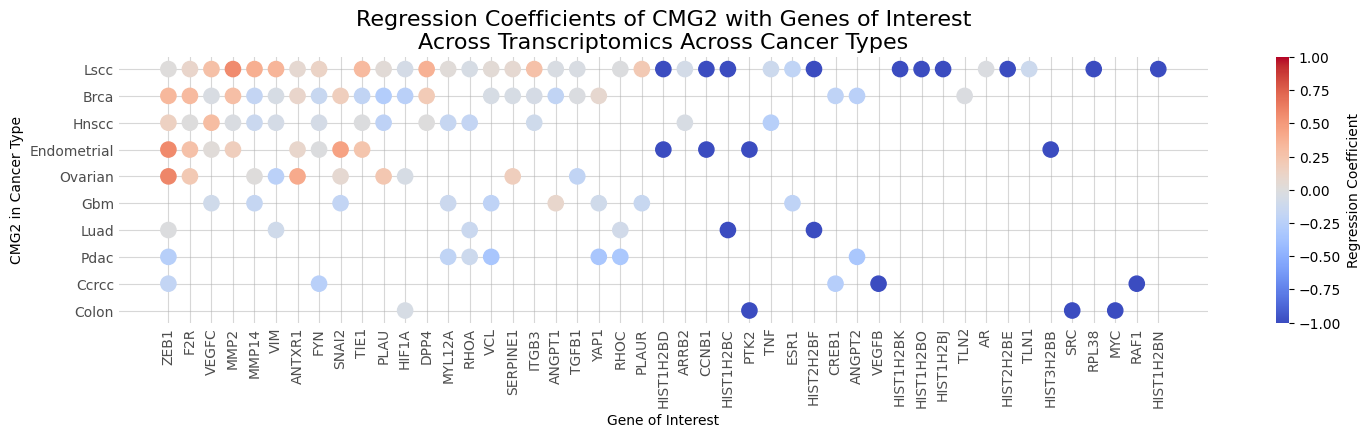

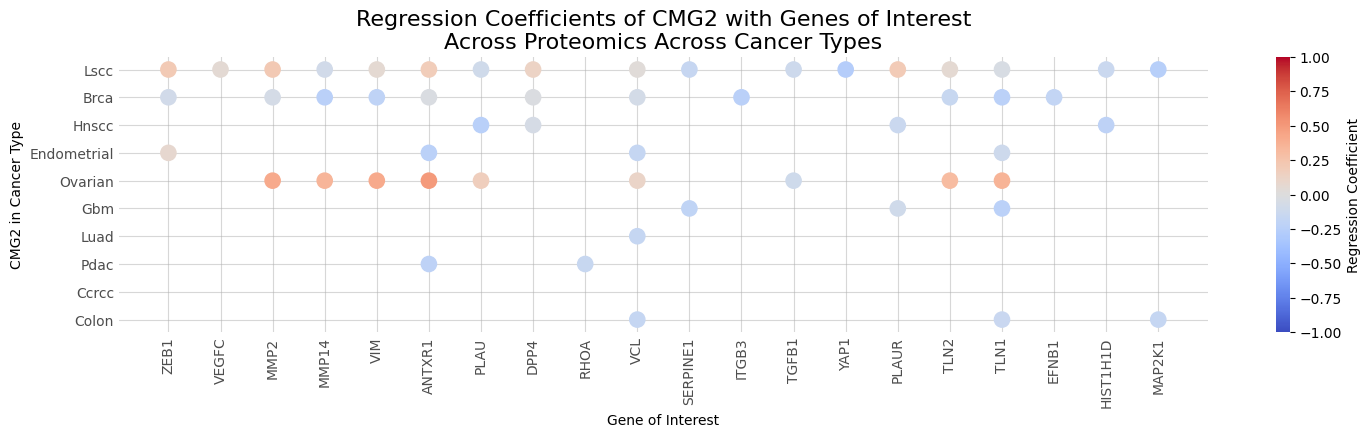

In [ ]:
ordered_cancer_types = None
ordered_genes = None
for omics_type in ['transcriptomics', 'proteomics']:
  coefficients, cdf, mask = create_correlation_df(dict_of_cancer_dfs, omics_type=omics_type)
  masked_coefficients = coefficients[mask]
  melted_coefficients = pd.melt(masked_coefficients.reset_index().rename(columns={'index': 'gene'}), id_vars='gene', value_vars=masked_coefficients.columns.tolist(), var_name='cancer_type', value_name='coefficient')

  melted_coefficients['abs_coefficient'] = melted_coefficients['coefficient'].abs()

  # create ordered lists based on the sum of absolute values of correlation cofficients
  if ordered_cancer_types is None:
    ordered_cancer_types = melted_coefficients.groupby('cancer_type')['abs_coefficient'].sum().reset_index().sort_values('abs_coefficient')['cancer_type'].tolist()
    ordered_genes = melted_coefficients.groupby('gene')['abs_coefficient'].sum().reset_index().sort_values('abs_coefficient')['gene'].tolist()

  # create categories from the ordered lists
  cancer_categories = pd.CategoricalDtype(categories=ordered_cancer_types, ordered=True)
  gene_categories = pd.CategoricalDtype(categories=ordered_genes, ordered=True)
  # convert the columns in the dataframe to categories in order to sort them
  melted_coefficients['cancer_type'] = melted_coefficients['cancer_type'].astype(cancer_categories)
  melted_coefficients['gene'] = melted_coefficients['gene'].astype(gene_categories)

  # sort the dataframe
  melted_coefficients = melted_coefficients.sort_values(by=['cancer_type', 'gene'], ascending=[True, False])

  # convert columns back to strings
  melted_coefficients['cancer_type'] = melted_coefficients['cancer_type'].astype(str)
  melted_coefficients['gene'] = melted_coefficients['gene'].astype(str)

  plot_correlation_heatmap(melted_coefficients, omics_type)



**FIGURE 3**

Given the unique increase of correlation between CMG2 mRNA and protein levels in cancer, we hypothesized that the differing roles CMG2 plays in cancer could be be instead be described by calculating the correlation coefficient between CMG2 and potential genes of interest. We hoped that if we were to find a specific protein that had a distinct correlation with CMG2 levels across cancer types associated with either high or low levels of CMG2, we we would be able to  identify potential interactors, downstream signaling targets, or upstream regulators of CMG2 that would be responsible for the increase of correlation in cancer. After a literature review of the role of CMG2, finding genes that could fit this description, and amassing a list of potential genes of interest, our data showed mixed results. Of the proteins that show significant correlation with CMG2, a handful of these proteins are already well characterized oncogenes that are known for their roles in cancer, independent of CMG2.

Surprisingly, there was a very strong correlation between the transcription abundance of CMG2 and the family of histone proteins. Extracellular histones have been previously reported as a potential biomarker and therapeutic target in certain diseases [[Karki et al., 2020](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7675882/)]. Conversely, previous unpublished confocal microscopy data has also shown CMG2 colocalization in the nucleus. We hypothesize that CMG2 could be interacting with the histone protein family in either of these two contexts and may mediate some form signaling that could either drive cancer development by interacting with DNA bound histones in the nuclues, or prevent an anti-cancer immune response by internalizing the extracellular histones that arose from neighboring cells that went through necroptosis [[Liu et al., 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6946014/)]. Further work includes performing a more in depth analysis in order to fully understand and validate the implications of this correlation.


**CONCLUSIONS AND FUTURE DIRECTIONS**

Our research validates the previously reported  phenomenon that CMG2 can be upregulated or downregulated in different cancer types. Additionally, we identify specific cancer types where CMG2 shows promise as a biomarker for early cancer detection. We observe an increase in correlation between CMG2 mRNA and protein levels when comparing normal tissue samples to tumor tissue samples. This suggests a change in CMG2 regulation in cancer. However, these correlations alone are insufficient to fully describe the variable expression of CMG2 in different cancer types. Although we identified some promising genes of interest that strongly correlate with CMG2 abundance, our analysis exhibits bias towards interactors that have been previously reported or hypothesized as CMG2 interactors, downstream targets, or upstream regulators. Future analysis will utilize machine learning methods, incorporating all differentially expressed genes available in the CPTAC dataset as potential descriptors of CMG2 variability in different cancer types. We will validate the most promising descriptors in a wet lab setting and elucidate the mechanism(s) driving variable CMG2 expression across different cancer types. This will provide further insights into the potential use of CMG2 as a cancer therapeutic target.